In [69]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib.ticker import MultipleLocator

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

# Functions

In [63]:
def get_vars(dirname, x_ind, t_end, flag):

    fname = "1_MCKNZ_1h_20170101_201701*"
    y = slice(1,-1,None)

    if flag == 'U':
        files = general_functions.get_files(dirname, fname, 'grid_U')
        varname = 'vozocrtx'
        maskname = 'umask'
    
    elif flag == 'V':
        files = general_functions.get_files(dirname, fname, 'grid_V')
        varname = 'vomecrty'
        maskname = 'vmask'
    
    elif flag == 'W':
        files = general_functions.get_files(dirname, fname, 'grid_W')
        varname = 'vovecrtz'
        maskname = 'tmask'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
    with scDataset(filesU) as dsU:
        sozotaux = dsU.variables['sozotaux'][:t_end,0,0]

    with scDataset(files) as ds:
        vel0 = ds.variables[varname][:t_end,:,y,x_ind]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
            mask0 = dsM.variables[maskname][0,:,y,x_ind]

    mask = np.tile(mask0, (len(sozotaux), 1, 1))

    vel = np.ma.array(vel0, mask=1 - mask)

    return vel

In [42]:
def get_mask(dirname):
    y, x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
            tmask = dsM.variables['tmask'][0,:,y,x]
            gdept = dsM.variables['gdept_1d'][0, :]
    return tmask, gdept

# x_ind's

In [56]:
x_indA, x_indB, x_indC, x_indD = 170, 190, 210, 230
t_end = 4*24

In [57]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_muscl_partial/'

# Mask and x_ind's

In [58]:
tmask, gdept = get_mask(dirname)

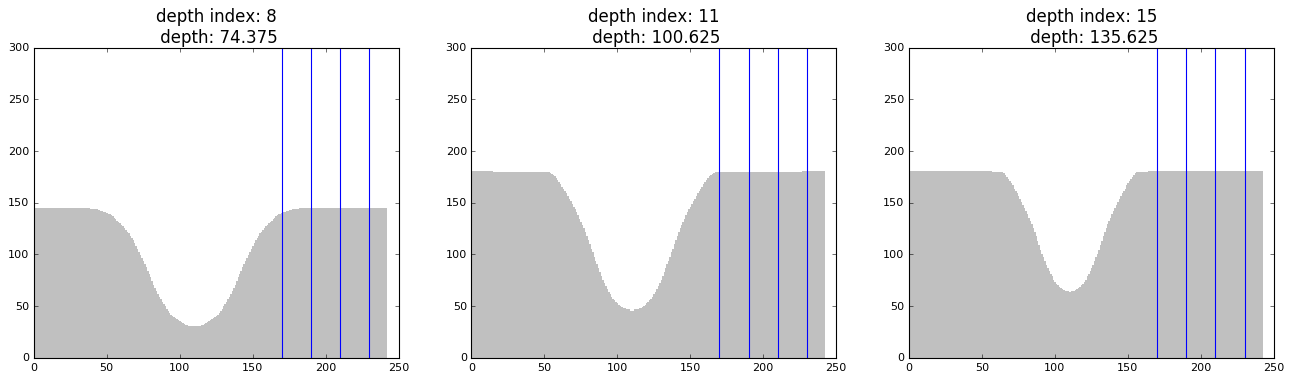

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, dep in zip(axes.flatten(), [8, 11, 15]):
    cmap_land = LinearSegmentedColormap.from_list('mycmap', ['silver', 'white'])
    ax.pcolormesh(tmask[dep, :, :], cmap=cmap_land)
    ax.set_title('depth index: '+str(dep)+'\n depth: '+str(gdept[dep]), fontsize=15)
    ax.axvline(x_indA)
    ax.axvline(x_indB)
    ax.axvline(x_indC)
    ax.axvline(x_indD)

# Velocity cross-sections

In [66]:
U_velA = get_vars(dirname, x_indA, t_end, 'U')
U_velB = get_vars(dirname, x_indB, t_end, 'U')
U_velC = get_vars(dirname, x_indC, t_end, 'U')
U_velD = get_vars(dirname, x_indD, t_end, 'U')

In [96]:
def plot_cross_section_time(time_ind):
    fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
    cmap = cmapIAM
    cmap.set_bad('silver')
    vmin, vmax = -0.5, 0.01
    for ax, this_vel in zip(axes.flatten(), [U_velA, U_velB, U_velC, U_velD]):
        p = ax.pcolormesh(this_vel[time_ind, :, :], cmap=cmapIAM, vmin=vmin, vmax=vmax)
        fig.colorbar(p, ax=ax, orientation='horizontal', pad=0.05)
        ax.set_xlim([0, this_vel.shape[-1]])
        ax.set_ylim([this_vel.shape[-2], 0])
    fig.tight_layout(w_pad=0.025)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    fig.suptitle('Hour: '+str(time_ind), fontsize=22)
    return fig

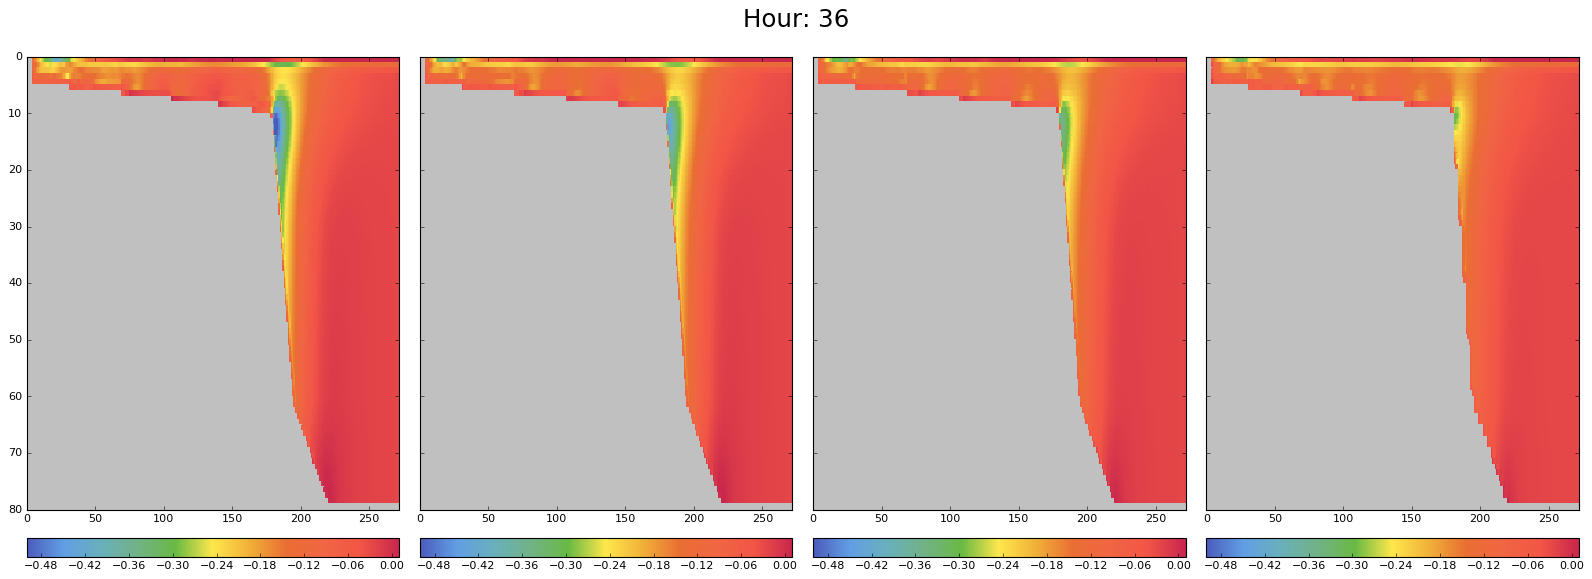

In [102]:
fig = plot_cross_section_time(36)

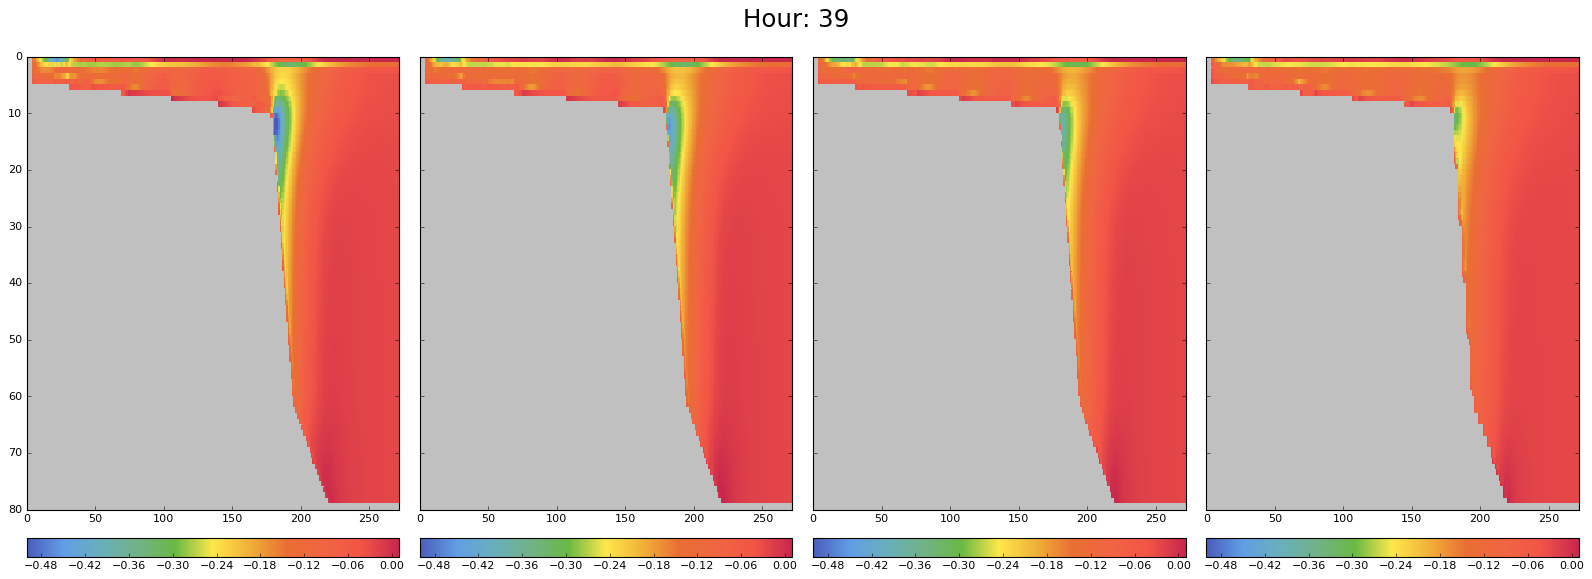

In [103]:
fig = plot_cross_section_time(36+3)

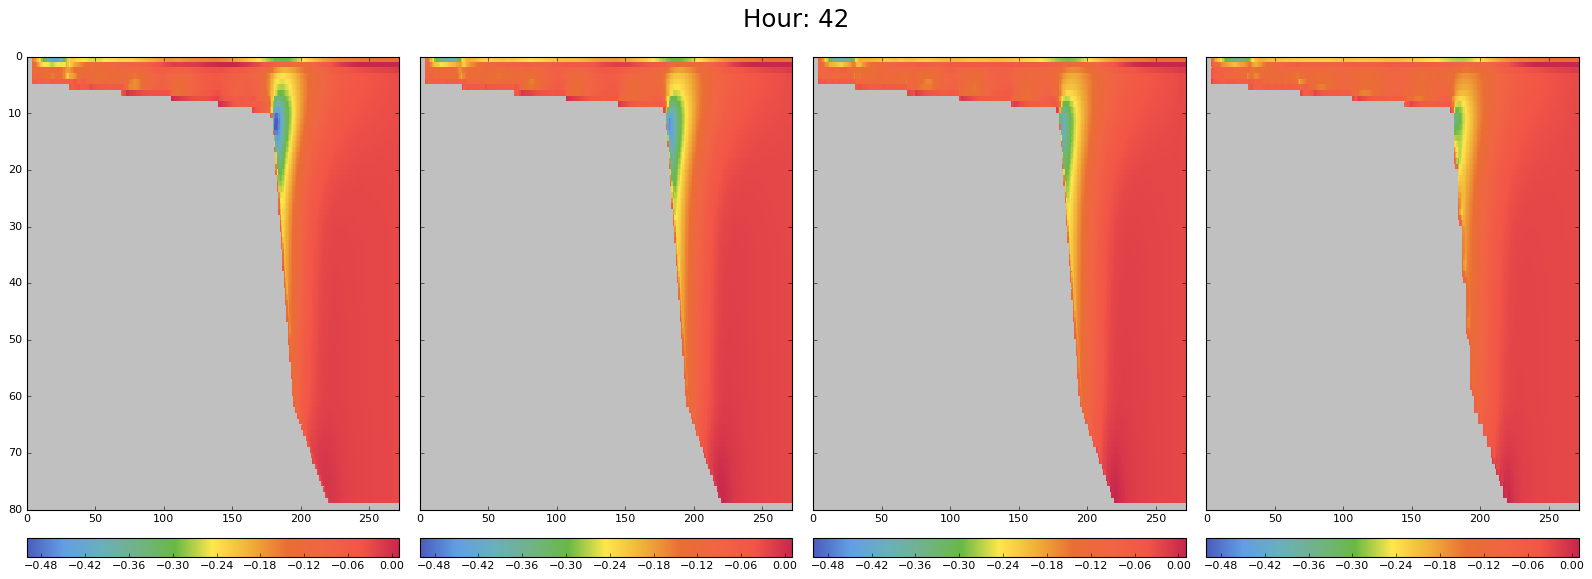

In [105]:
fig = plot_cross_section_time(36+6)